In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
house = pd.read_csv('CLEAN_REFIT_081116/CLEAN_House6.csv',nrows = 4000000)
house['Time'] = pd.to_datetime(house['Time'])
house_time_index = house.set_index('Time').copy()
house_time_index.drop(columns=['Unix','Issues'], inplace=True)
only_aggregate = house_time_index.drop(columns=['Appliance1', 'Appliance2', 'Appliance3', 'Appliance4', 'Appliance5', 'Appliance6', 'Appliance7', 'Appliance8', 'Appliance9'])
full_days = only_aggregate[(only_aggregate.index.date > only_aggregate.index.min().date()) & (only_aggregate.index.date < only_aggregate.index.max().date())]
peaks_cut = full_days[full_days['Aggregate'] < 10500]
measurements = peaks_cut

In [18]:
def scatter_plot(DataFrame):
    fig, ax = plt.subplots()
    ax.scatter(DataFrame.index, DataFrame['Aggregate'], s=.5) # 's=10' makes the dots smaller
    plt.xlabel('Time') # Set the x-axis label to 'Time'
    plt.ylabel('Aggregate') # Set the y-axis label to 'Aggregate'
    plt.show()

In [88]:
def big_plot(dataframe):
    dataframe.plot(linewidth=1, figsize=(20,20))

In [69]:
def process_sequences(dataframe):
    sequences = []
    current_sequence = {'start_time': None, 'end_time': None, 'values': []}
    prev_idx = None  # Keep track of the previous row's index

    for idx, row in dataframe.iterrows():
        value = row['Aggregate']
        
        # Start a new sequence if it's the first value or the value changes significantly
        if not current_sequence['values'] or abs(value - current_sequence['values'][-1]) / current_sequence['values'][-1] > 0.05:
            if current_sequence['values']:
                # Finalize the current sequence using the previous row's timestamp as the end time
                current_sequence['end_time'] = prev_idx
                sequences.append(current_sequence)
                # Start a new sequence
                current_sequence = {'start_time': idx, 'end_time': None, 'values': [value]}
            else:
                # This is the first value in the sequence
                current_sequence['start_time'] = idx
                current_sequence['values'].append(value)
        else:
            # Continue the current sequence
            current_sequence['values'].append(value)
        
        prev_idx = idx  # Update the previous index at the end of the loop

    # Finalize the last sequence using the last known timestamp as the end time
    if current_sequence['values']:
        current_sequence['end_time'] = prev_idx
        sequences.append(current_sequence)

    start_time_data = {
        'Time': [seq['start_time'] for seq in sequences],
        'Aggregate': [sum(seq['values']) / len(seq['values']) for seq in sequences]
    }
    end_time_data = {
        'Time': [seq['end_time'] for seq in sequences],
        'Aggregate': [sum(seq['values']) / len(seq['values']) for seq in sequences]
    }

    start_time_data_df = pd.DataFrame(start_time_data)
    end_time_data_df = pd.DataFrame(end_time_data)

    result_df = pd.concat([start_time_data_df, end_time_data_df], ignore_index=True)
    concatenated_result_df = result_df.sort_values(by='Time').set_index('Time')


    return concatenated_result_df[~concatenated_result_df.index.duplicated(keep='first')]

In [57]:

original_data = measurements['2013-11-29 06:00:00':'2013-11-29 9:00:00']
processed_data = process_sequences(original_data)
expanded_processed_data = processed_data.reindex(original_data.index, method='ffill')
correlation = original_data['Aggregate'].corr(expanded_processed_data['Aggregate'])

print(f"Correlation coefficient: {correlation}")

Correlation coefficient: 0.998991139932677


In [71]:
original_data = measurements['2013-11-29 06:00:00':'2013-11-29 9:00:00']
processed_data = process_sequences(original_data)


In [79]:
original_data_unique = original_data.groupby(original_data.index).mean()
processed_data = process_sequences(original_data_unique)
expanded_processed_data = processed_data.reindex(original_data_unique.index, method='ffill')
correlation = original_data_unique['Aggregate'].corr(expanded_processed_data['Aggregate'])
print(f"Correlation coefficient: {correlation}")

Correlation coefficient: 0.998991139932677


In [89]:

def cumulate_consumption(dataframe):
    end_times = dataframe.index.to_series().shift(-1) - pd.Timedelta(seconds=1)

    time_diffs_seconds = (end_times - dataframe.index.to_series()).dt.total_seconds().fillna(method='ffill')

    time_diffs_hours = time_diffs_seconds / 3600

    dataframe['Energy'] = dataframe['Aggregate'] * time_diffs_hours

    dataframe['Cumulative Energy'] = dataframe['Energy'].cumsum()

    return dataframe

C:\Users\malte\AppData\Local\Temp\ipykernel_26568\1746730285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Energy'] = dataframe['Aggregate'] * time_diffs_hours
C:\Users\malte\AppData\Local\Temp\ipykernel_26568\1746730285.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Cumulative Energy'] = dataframe['Energy'].cumsum()


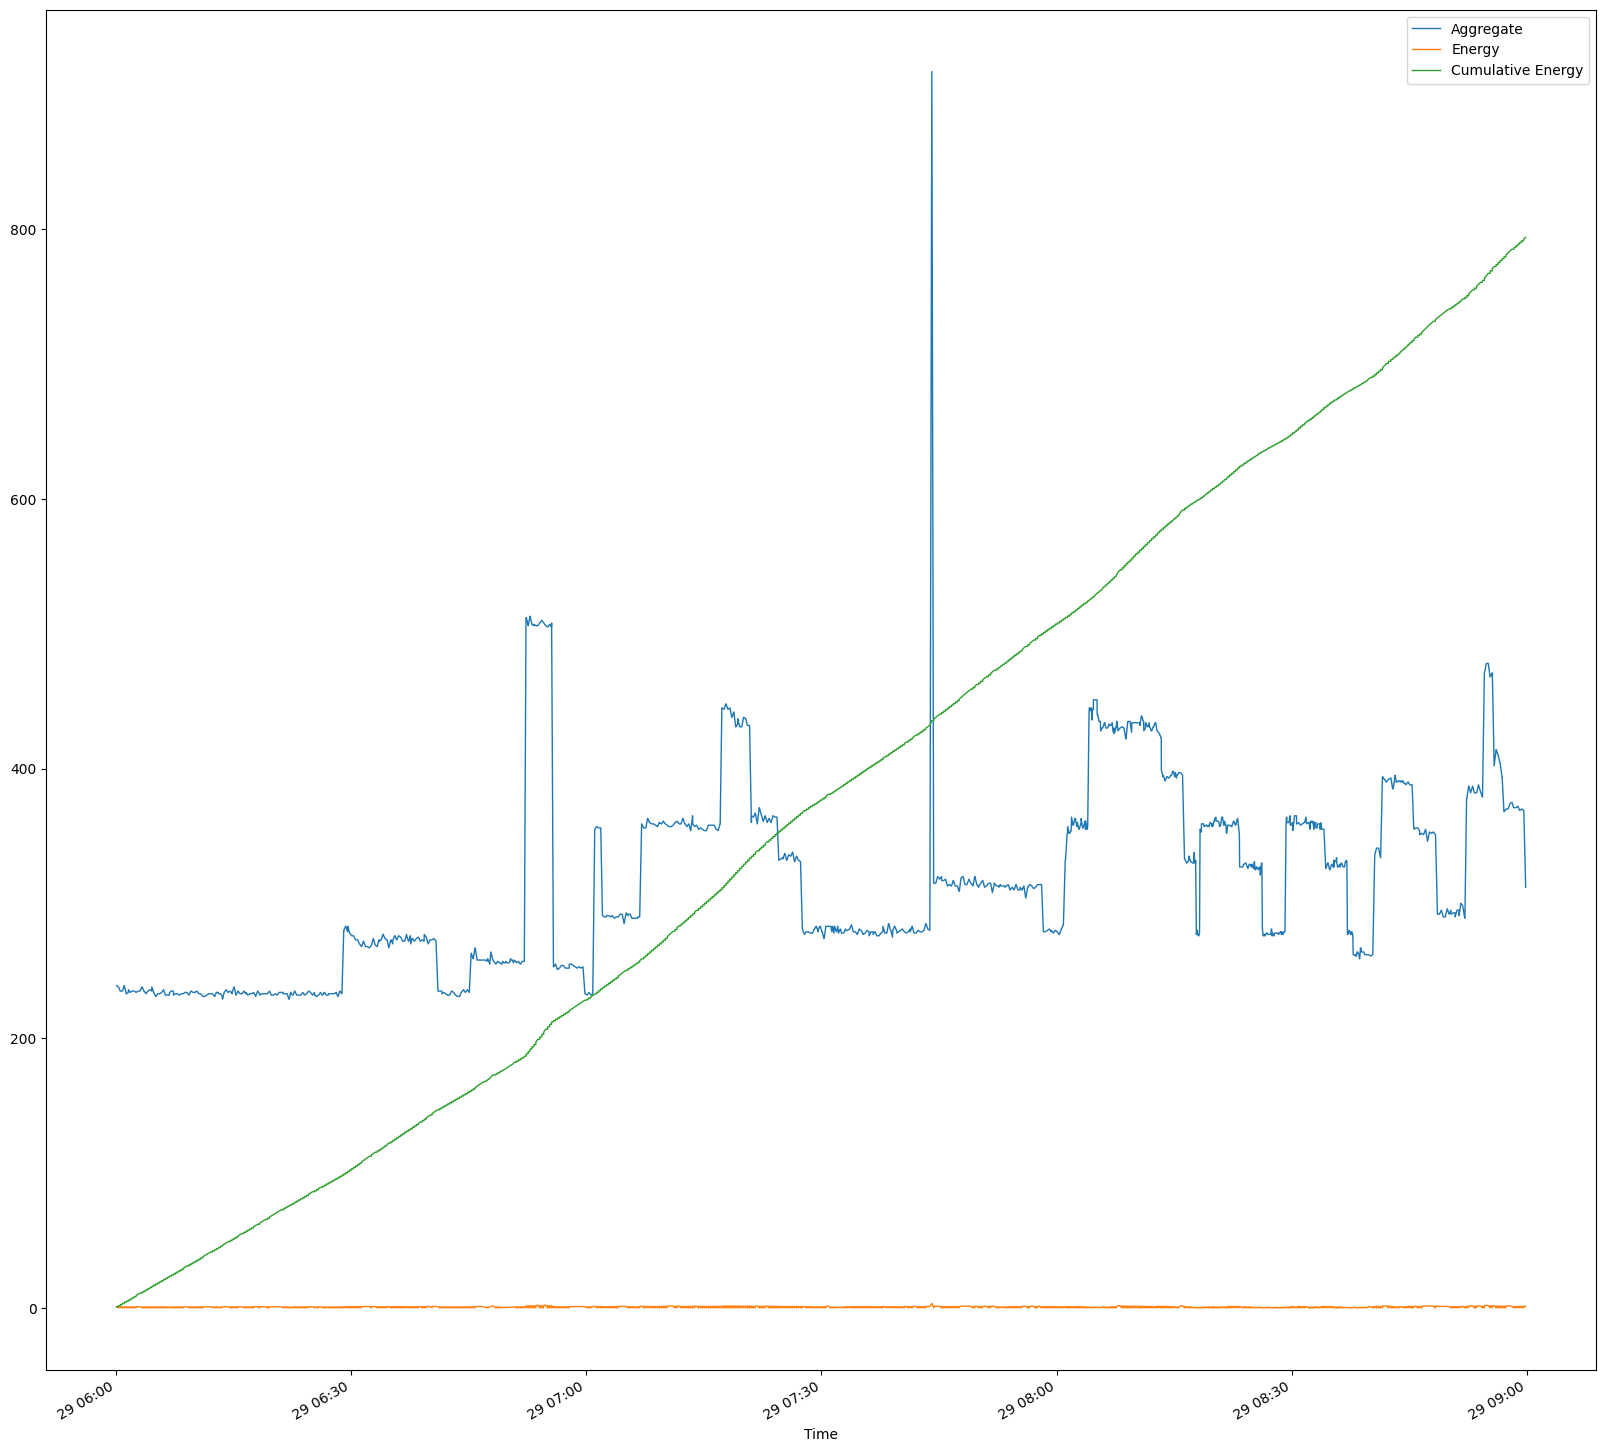

In [91]:
big_plot(cumulate_consumption(original_data))

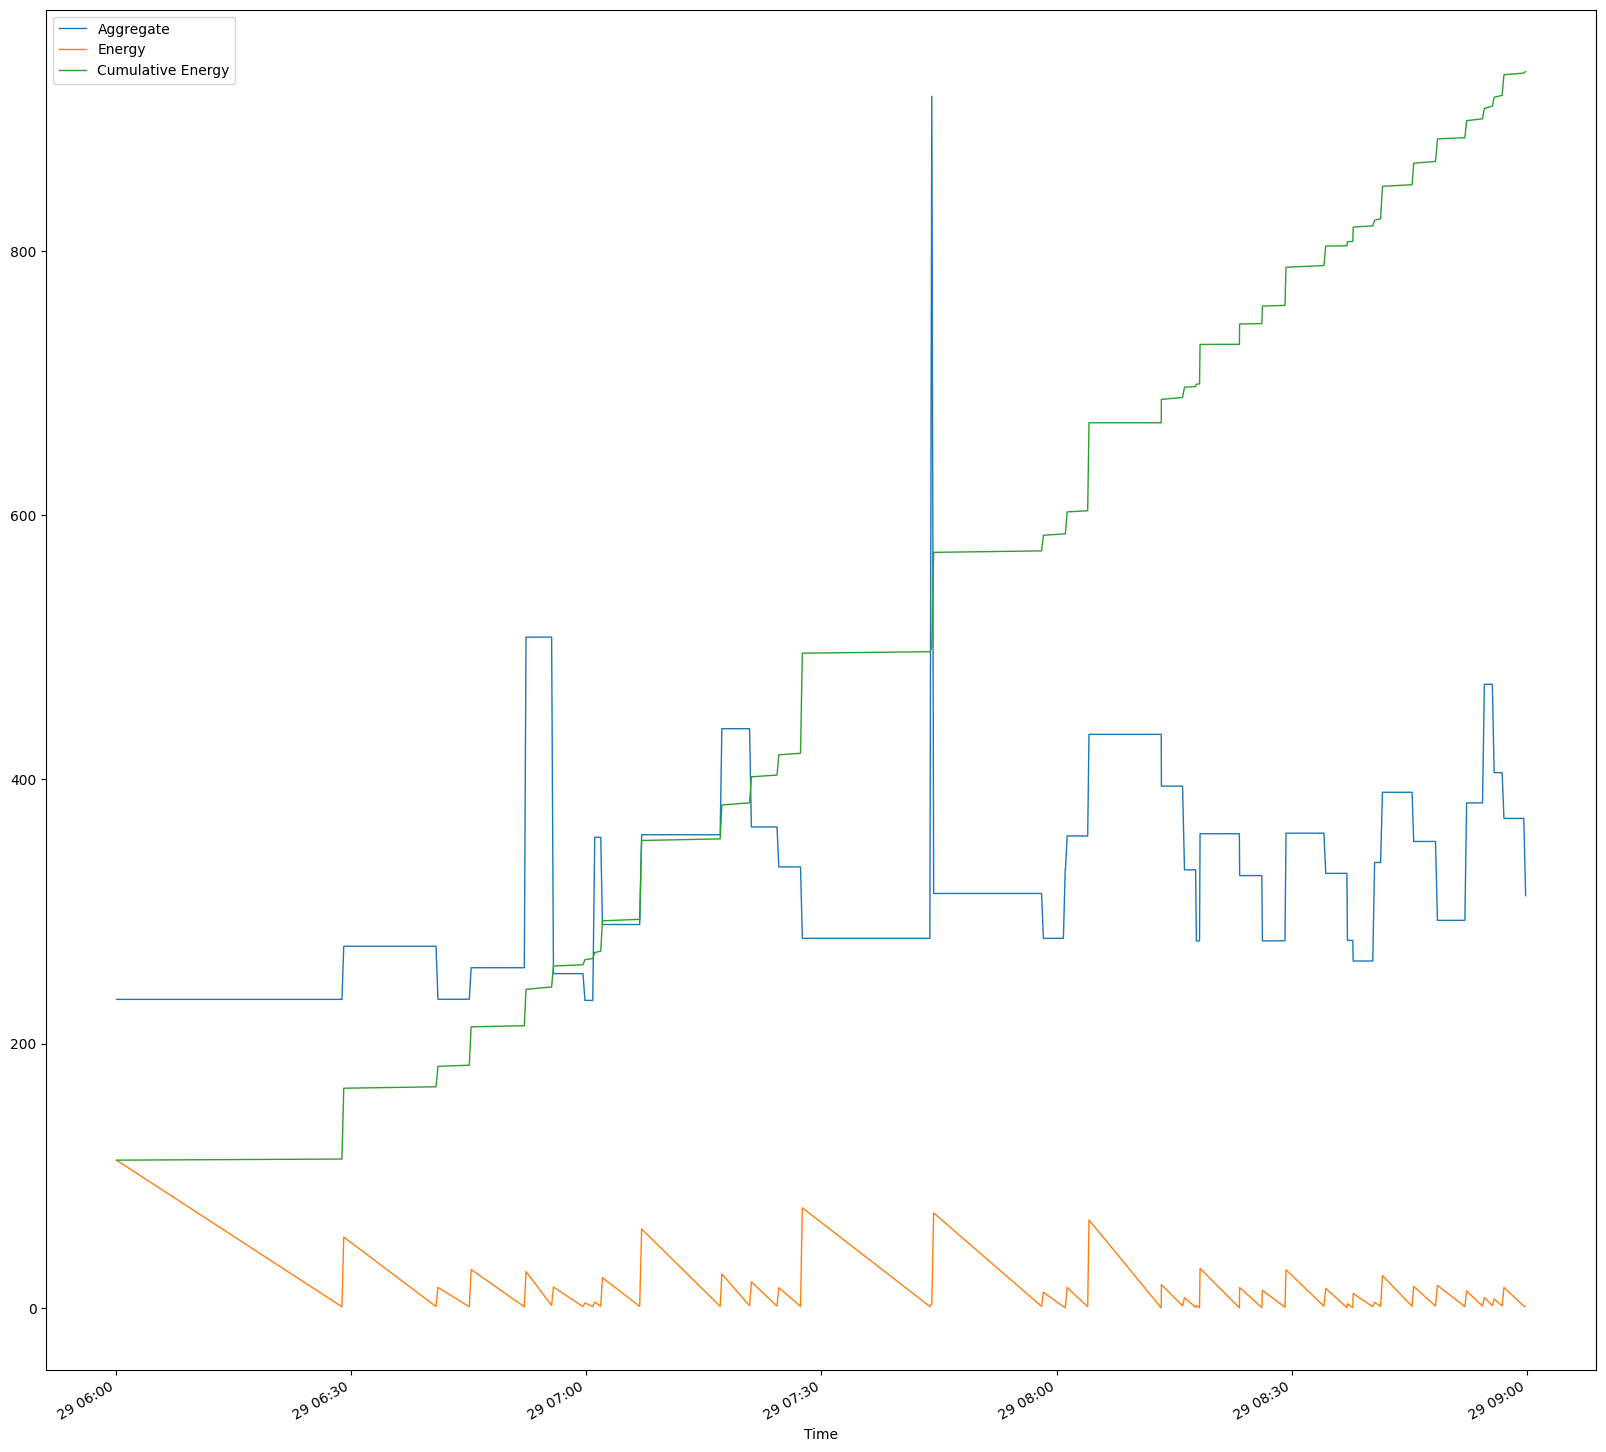

In [93]:
big_plot(cumulate_consumption(processed_data))

In [94]:
processed_data.head(15)

,Aggregate,Energy,Cumulative Energy
Time,,,
2013-11-29 06:00:05,233.513514,111.827027,111.827027
2013-11-29 06:28:50,233.513514,0.843243,112.670270
2013-11-29 06:29:04,273.736264,53.606685,166.276955
2013-11-29 06:40:50,273.736264,1.064530,167.341485
2013-11-29 06:41:05,233.606061,15.508847,182.850332
2013-11-29 06:45:05,233.606061,0.843577,183.693909
2013-11-29 06:45:19,257.482143,29.038264,212.732173
2013-11-29 06:52:06,257.482143,0.858274,213.590447
2013-11-29 06:52:19,507.689655,27.499856,241.090303
